In [1]:
import sys
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats 
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier, load_classifier_and_data
from custom_procs import plot_confusion_matrix

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [49]:
def make_visualisations(df, features, vis='hist', n_cols=2, figsize=(15,40), 
                        bins=50, **kwds):
    '''
    Make histrograms or boxplots for all items in features list from a pandas 
    dataframe.
    Parameters
    - df: Pandas dataframe. Dataframe with all data.
    - features: List. List of features to be plotted. Must be numerical 
    features. NaN values will be dropped.
    - vis: Str. Type of visualisation: [hist or boxplot]
    - n_cols: Integer. Number of columns for the histogram matrix.
    - figsize: Tuple (w,h). Size of histograms matrix.
    - bins: Integer. Number of bins in the histogram.
    '''
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=.3)
    for i in range(len(features)):
        ax=fig.add_subplot(round(len(features)/n_cols+.5),n_cols,i+1)
        data=df[features[i]].dropna()
        if vis=='hist':
            ax.hist(data,bins=bins, **kwds)
        elif vis=='boxplot':
            ax.boxplot(data, **kwds)
        else:
            print('Invalid visualisation')
            break
        ax.title.set_text(features[i])
    plt.show()
    
def outliers(df, feature):
    """
    Returns rows that are considered outliers for a given feature.
    Outlier definition: (Q1-1.5IQR,Q3+1.5IQR)
    Parameters:
    - df: Pandas dataframe. Dataframe that contains data.
    - feature: Str. Name of feature to be explored.
    """
    iqr = stats.iqr(df[feature].dropna())
    third_quantile = df[feature].quantile(0.75)
    first_quantile = df[feature].quantile(0.25)
    outliers = (first_quantile-1.5*iqr,third_quantile+1.5*iqr)
    return df[(df[feature]<outliers[0]) | (df[feature]>outliers[1])][['full_name',feature]]\
    .sort_values(by=feature)

In [51]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index':'full_name'}, inplace=True)

# classifying the columns and modifying dataframe
continuous_features = ['salary', 'deferral_payments', 'total_payments', 
                      'loan_advances', 'bonus', 'restricted_stock_deferred', 
                      'deferred_income', 'total_stock_value', 'expenses', 
                      'exercised_stock_options', 'other', 'long_term_incentive',
                      'restricted_stock', 'director_fees', 'to_messages', 
                       'from_poi_to_this_person', 'from_messages', 
                       'from_this_person_to_poi', 'shared_receipt_with_poi']

email_features= ['to_messages', 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi', 'shared_receipt_with_poi']

for feat in continuous_features:
    df[feat]=df[feat].astype(float)
    
# checking the proportion of available data per feature
available_data = pd.DataFrame(
    [{'feature':f,
      'available':df[f].count(),
      'poi':df.query(f'{f}=={f} & poi==True')[f].shape[0],
      'total':df.shape[0]} 
     for f in continuous_features])
available_data=available_data[['feature','total','available','poi']]
available_data['prop_available']=available_data.available/available_data.total
available_data['prop_poi_total']=available_data.poi/available_data.total
available_data['prop_poi_available']=available_data.poi/available_data.available

# looking at features that have at least 50% of data available
feats = list(available_data[available_data.prop_available>=.5].feature)

rows_to_remove = [84,130,127]
df.drop(rows_to_remove, axis=0, inplace=True)

# correct incorrect entry
nan_cols = [1,6,18,9,3,5,15,21]
valid_cols=[11,4,13,20,8,10]
cols_values=[137864, 137864, 15456290, 2604490, -2604490, 15456290]
df.iloc[11,valid_cols]=cols_values
df.iloc[11,nan_cols]=np.nan

features_list = ['poi']+feats+['deferral_payments','director_fees',
                               'deferred_income', 'long_term_incentive']

# checking for the number of missing (relevant) features per row
df['missing_cols']=df[features_list].apply(lambda x: x!=x).sum(axis=1)

Source: __[Wikipedia](https://en.wikipedia.org/wiki/Enron)__

Enron Corporation was an American energy, commodities, and services company based in Houston, Texas. It was founded in 1985 as a merger between Houston Natural Gas and InterNorth, both relatively small regional companies. Before its bankruptcy on December 2, 2001, Enron employed approximately 20,000 staff and was a major electricity, natural gas, communications and pulp and paper company, with claimed revenues of nearly $101 billion during 2000. Fortune named Enron "America's Most Innovative Company" for six consecutive years.

 At the end of 2001, it was revealed that Enron's reported financial condition was sustained by institutionalized, systematic, and creatively planned accounting fraud, known since as the Enron scandal. Enron has since become a well-known example of willful corporate fraud and corruption. The scandal also brought into question the accounting practices and activities of many corporations in the United States and was a factor in the enactment of the Sarbanes–Oxley Act of 2002. The scandal also affected the greater business world by causing the dissolution of the Arthur Andersen accounting firm, which had been Enron's main auditor for years. 

 Enron filed for bankruptcy in the Southern District of New York in late 2001 and selected Weil, Gotshal & Manges as its bankruptcy counsel. It ended its bankruptcy during November 2004, pursuant to a court-approved plan of reorganization. A new board of directors changed the name of Enron to Enron Creditors Recovery Corp., and emphasized reorganizing and liquidating certain operations and assets of the pre-bankruptcy Enron. On September 7, 2006, Enron sold Prisma Energy International Inc., its last remaining business, to Ashmore Energy International Ltd. (now AEI). 
 
<img src="878px-Logo_de_Enron.svg.png" alt="Enron Logo" title="Enron Logo" style="width: 300px;" />

<div class="alert alert-block alert-info">
<h2>Project Case and Data Introduction</h2>
<br>
Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those? Relevant rubric items: “data exploration”, “outlier investigation”
</div>

**Project Goal**<br>
In this project, I will build a machine learning classifier that will identify persons of interest (POI) in a fraud case given a number of available features.

**Dataset**<br>
The dataset used for this project consists of 146 individual entries of possible persons of interest with 21 available features. In addition there are 178,352 outgoing email messages and 52,356 incoming email messages from 86 different mailboxes available that could also be used to generate a text classifier.

This dataset can be used to find persons that should be investigated further given the combination of values in the available features.

There were a large number of missing values in the dataset. Firstly I reviewed the data availability for each feature and filtered all columns that had less than 50% data availability (`feats`). Next, I reviewed the definition of all features and added features that would possibly have a predictive value and are not necessarily available in at least 50% of the rows. I then reviewed the number of missing features for each row and removed all rows that had more than 17 missing features. Visually checking the features highlighted an entry for a person called 'THE TRAVEL AGENCY IN THE PARK'. Given that this project aims to identify persons of interest, I removed that entry as it referred to a business.

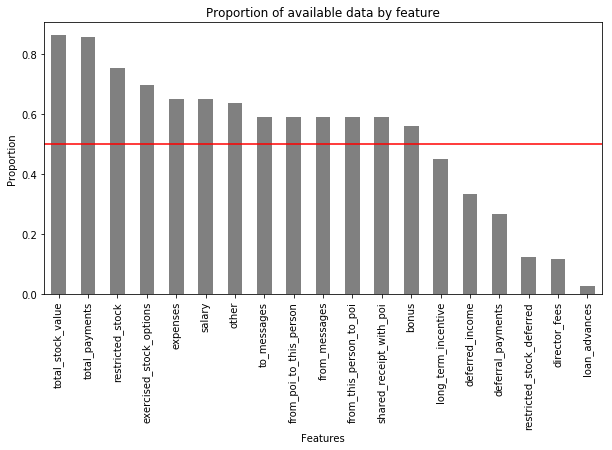

In [48]:


available_data.set_index('feature').sort_values(by='prop_available', 
                                                ascending=False)\
    .prop_available.plot(kind='bar',color='grey', figsize=(10,5))
plt.hlines(y=0.5, xmin=-1, xmax=len(available_data.feature),colors='r')
plt.title('Proportion of available data by feature')
plt.xlabel('Features')
plt.ylabel('Proportion');

**Outliers**<br>
After ploting boxplots for the selected features (`features list`), I found a row that was brought from the spreadsheet with the total sum for all columns and removed it.<br>
Creating boxplots again shows a more 'normal' number of outliers to be investigated. Results below:

- Salary: All high-valued outliers appear to be valid data points; however, low-valued datapoints appear to be incorrect. James Bannantine and Rodney Gray both held executive positions while Richard Westfahl served as managing director. The stated salaries appear to be too low for said positions. Nevertheless, I could not find any evidence that would point to a different salary and as such, the data found was used for the analysis. 
- BHATNAGAR SANJAY: This entry had negative restricted stock and positive restricted deferred stock values. This would mean that the employee owed stock to the company and that the deferred stock was paid to the employee rather than being deferred for future payment. Upon further investigation I found that this entry had data entry errors which were corrected before proceeding with the analysis.

All other outliers appeared to be valid entries and were used for the analysis.

**Missing Data**<br>
After removing features with a large amount of missing data, missing datapoints were filled with zeroes for compatibility with the algorithms. Another possibility would involve investigating the median or average value of each feature. Research which features would apply to all entries (salary, email, etc.) and fillwith the value. Values such as director fees for which only a minority of entries would have valid data could be handled by filling missing values with zeroes or ignored alltogether if the feature does not prove to have any significance.

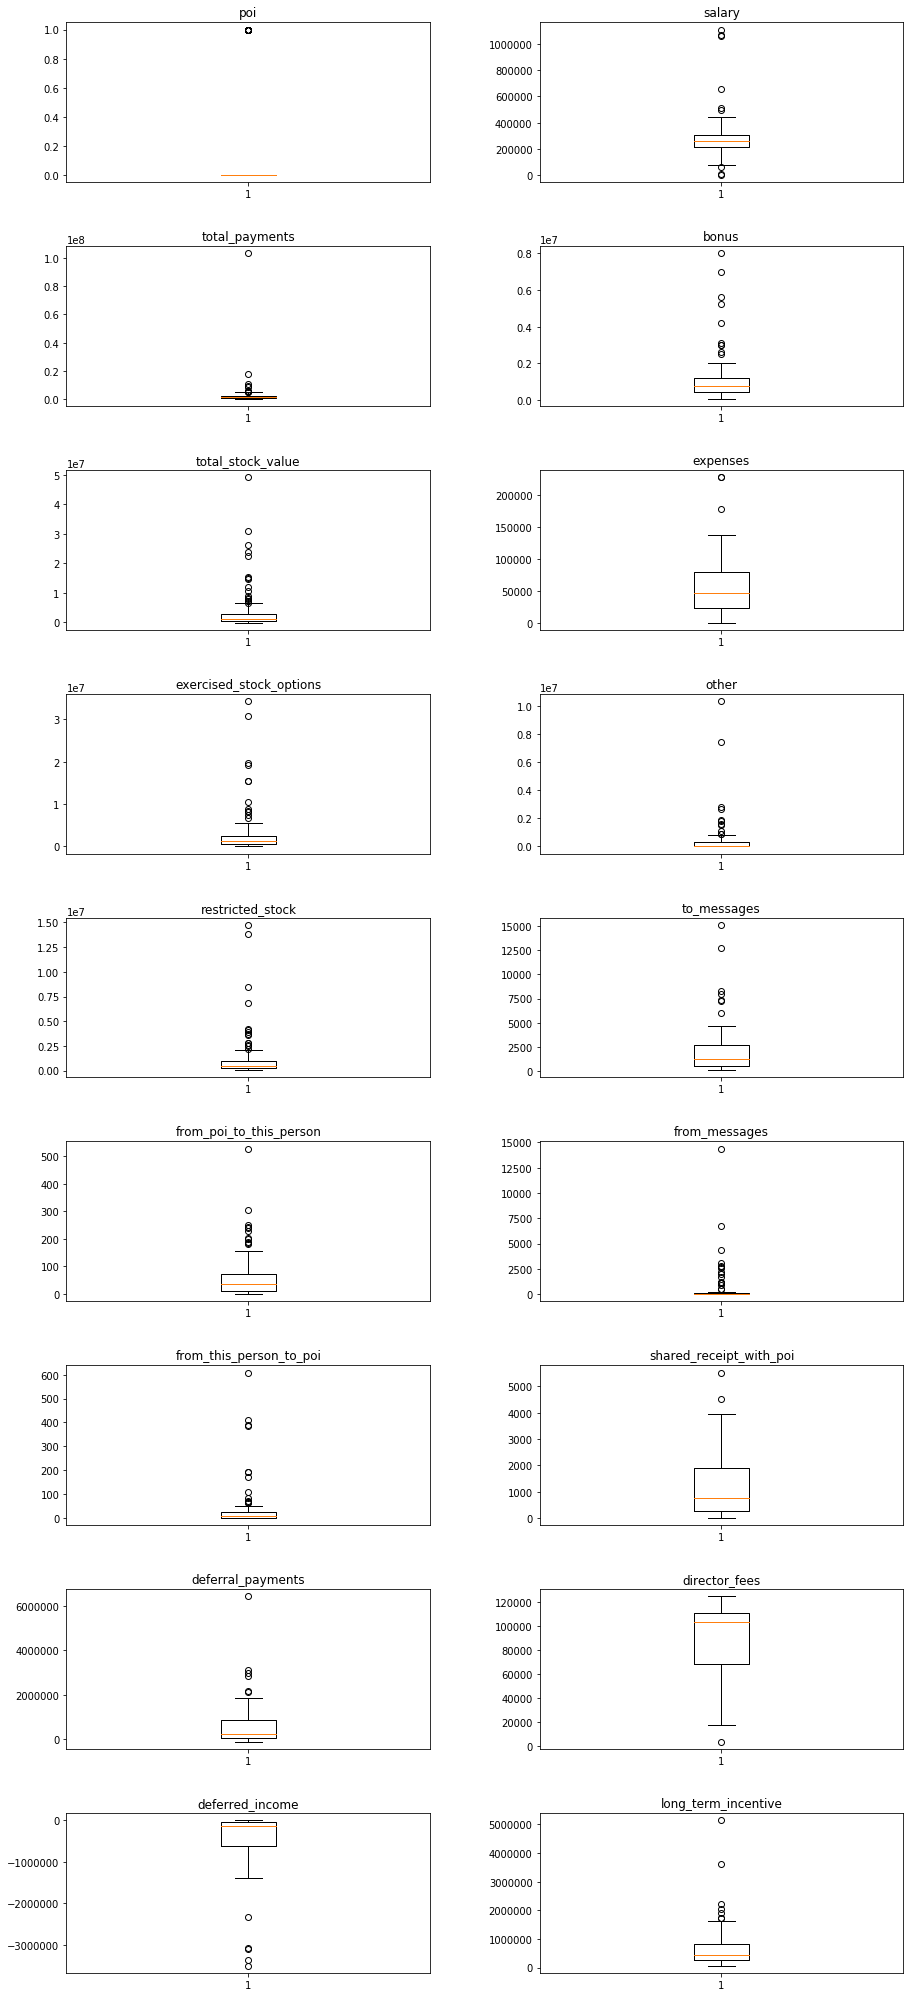

In [52]:
make_visualisations(df, features_list, vis='boxplot')

<div class="alert alert-block alert-info">
<h2>Features</h2>
<br>
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]
</div>

**Features Used and Selection Process**

Features used:
- salary
- total_payments
- bonus
- total_stock_value
- expenses
- exercised_stock_options
- other
- restricted_stock
- from_poi_to_this_person
- shared_receipt_with_poi
- deferred_income
- long_term_incentive
- to_poi_proportion
- bonus_to_salary

Selection Process:<br>
Firstly I selected only features that had at least 50% data availability. Next I reviewed the feature definitions and added features that could have some predictive value even if they had less than 50% data availability. These features include deferral_payments, director_fees, deferred_income, and long_term_incentive. I would assume that some of the POIs would be receiving special privileges likely reflected in the aforementioned features.

The final algorithm used was a random forest classifier with 200 estimators. No scaling was required as the algorithm does not measure distances between points and is not affected by outliers. 

**Feature Engineering**

I engineered four features:
- from_poi_proportion: proportion of received messages from POI out of total received messages
- to_poi_proportion: proportion of sent messages to POI out of total sent messages
- bonus_to_salary: ratio of bonus received as compared to salary
- restricted_to_total_stock: proportion of restricted stock to total stock value


For both `from_poi_proportion` and `to_poi_proportion` my hypothesis was that a POI would have a higher rate than the average employee. On average POIs received 1.36x more emails from other POIs than non-POIs did. Similarly, POIs sent 2.36x more emails to other POIs than non-POIs did.

**Selecting the Final Features**

Finally, I used an sklearn's SelectKBest feature selection method to narrow the features used to those that had a p-value<=.05.

In [39]:
feat_selection.query('p_value<=0.05').sort_values(by='score', ascending=False)

,feature,p_value,score
3,total_stock_value,0.000005,22.511922
5,exercised_stock_options,0.000005,22.348834
2,bonus,0.000011,20.792252
0,salary,0.000035,18.289684
18,to_poi_proportion,0.000084,16.409713
15,deferred_income,0.000922,11.458477
19,bonus_to_salary,0.001292,10.783585
16,long_term_incentive,0.001994,9.922186
1,total_payments,0.002763,9.281862
7,restricted_stock,0.003487,8.828679


<div class="alert alert-block alert-info">
<h2>Classifiers</h2>
<br>
This section includes Task 5
<br><br>
What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms? [relevant rubric item: “pick an algorithm”]
</div>

The final algorithm used was a Random Forests Classifier.

I tested Naive Bayes, Decision Tree, Random Fores and AdaBoost classifiers. Overall, performance deteriorated when trying to optimise all the parameters in the classifiers. The best results where obtained when trying a large number of more general classifiers rather than a smaller number of highly specific classifiers.

In my results it appered that biased classifiers performed better and were more generisable when testing.

<div class="alert alert-block alert-info">
<h2>Parameter Tunning</h2>
<br>This section includes Task 5
<br><br>
What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]
</div>

Machine learning algorithms have a variety of parameters that can be adjusted to improve the information extraction from the available data. Proper tuning improves the algorithm's ability to learn from the data and provide accurate results that are general enough to be applicable in a range of similar problems and specific enough to provide relevant solutions to a type of problem.

It also helps produce a model with the right tradeoff of bias and variance. When parameter tunning is not properly done, the model might end up being highly biased (too general) or with high variance (too specific).

My final algorithm was tunned using sklearns GridSearchCV tool. After researching how the parameters of each algorithm would affect the training of said algorighm, I created a parameters grid that is automatically explored by GridSearchCC. The best parameters are then used to predict classes.

The algorithms that provided the best classificatinon power where those with higher bias, more generisable.

<div class="alert alert-block alert-info">
<h2>Validation</h2>
<br>This section includes Task 5
<br><br>
What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]
</div>

Validation is the evaluation of the trained model against a testing dataset previously unknown to the algorithm.

As mentioned above, it is important that the data used to validate the performance has not been seen by the algorithm during the training phase. This would cause the algorithm to overfit and would likely perform poorly when used in a different dataset.

Validation of the data was done through StartiffiedShuffleSplit. With this technique, the algorithm is trained and tested with the entire dataset. This allows for increased performance as the algorithm is trained and tested several times. I used this technique as it is the technique that the algorithm will ultimately be tested against. This would allow me to optimise it to perform at the required level for this type of testing.

<div class="alert alert-block alert-info">
<h2>Evaluation Metrics</h2>
<br>This section includes Task 5
<br><br>
Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]
</div>

The final algorithm was measured against recall and precision. Success was defined as recall and precision greater or equal to 0.3.

- Precision: proportion of correctly classified POIs out of all the true POIs
- Recall: proportion of correctly classified POIs out of all the individuals classified as POIs.

The final algorithm had an accuracy of 0.87 with precision of 0.54 and recall of 0.3. This algorithm would tend to assume innocence unless there is overwhelming evidence of the contrary. It more readily classifies someone as non-POI than POI. 

While the classifier does meet the project goal, it might need further development if it is to be used as a starting point for law enforcement investigations where it might be more suitable to lower the threshold of culpability and classify more non-PoIs as PoIs.

<img src="final_results.png" alt="Final Results" title="Final Results" style="width: 600px;" />